# PROYECTO 3 - Security Data Science
### Parte 2 - Ataque de evasión

In [1]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from art.estimators.classification import KerasClassifier
import keras
from tensorflow.keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Rescaling, InputLayer, Reshape
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.defences.postprocessor import ReverseSigmoid
from keras.preprocessing.image import ImageDataGenerator
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import TensorFlowV2Classifier
import joblib

C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\art\estimators\certification\__init__.py:12: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")


In [2]:
# Escribir aqui el path de la carpeta con imagenes. Usar doble \\ para el path
path_root = "D:\\UVG\\9noSemestre\\SecurityDataScience\\Proyecto3---Security-DS\\malimg_dataset\\malimg_paper_dataset_imgs\\"

In [3]:
batches = ImageDataGenerator().flow_from_directory(directory = path_root, target_size = (64, 64), batch_size = 10000)

Found 9339 images belonging to 25 classes.


In [4]:
# Usamos next() para recorrer todos los elementos y generar un batch de imagenes y label del data set
imgs, labels = next(batches)

In [5]:
# nuestras imagenes estan en RGB con formato 64x64 [width x length x depth].
imgs.shape

(9339, 64, 64, 3)

In [6]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Entrenamiento y prueba
Se divide la data en 55% train y 45% test 

In [7]:
X_train, X_test0, y_train, y_test0 = train_test_split(imgs, labels, test_size = 0.15)

In [8]:
X_train.shape

(7938, 64, 64, 3)

In [9]:
y_train.shape

(7938, 25)

In [10]:
y_train_new = np.argmax(y_train, axis=1) # se extraen solo las clases
y_train_new

array([ 2,  2, 21, ...,  2,  2, 13], dtype=int64)

In [11]:
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

### Modelo original

In [12]:
num_classes = 25 # se especifica la cantidad de clases de imagenes para clasificar

def get_original_model():
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(64, 64,3)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', 
            metrics=['accuracy'])

    return model

In [13]:
original_model = get_original_model()

In [14]:
original_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0

In [15]:
original_model.fit(X_train, y_train, batch_size=10, validation_data=(X_test0, y_test0), epochs=5)

Train on 7938 samples, validate on 1401 samples
Epoch 1/5
7930/7938 [============================>.] - ETA: 0s - loss: 0.4895 - accuracy: 0.8607

C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7938/7938 [==============================] - 24s 3ms/sample - loss: 0.4891 - accuracy: 0.8608 - val_loss: 0.1373 - val_accuracy: 0.9529
Epoch 2/5
7938/7938 [==============================] - 23s 3ms/sample - loss: 0.1240 - accuracy: 0.9631 - val_loss: 0.1017 - val_accuracy: 0.9700
Epoch 3/5
7938/7938 [==============================] - 23s 3ms/sample - loss: 0.0815 - accuracy: 0.9747 - val_loss: 0.1174 - val_accuracy: 0.9650
Epoch 4/5
7938/7938 [==============================] - 23s 3ms/sample - loss: 0.0616 - accuracy: 0.9809 - val_loss: 0.1054 - val_accuracy: 0.9679
Epoch 5/5
7938/7938 [==============================] - 22s 3ms/sample - loss: 0.0664 - accuracy: 0.9795 - val_loss: 0.1099 - val_accuracy: 0.9679


### Modelo robusto

In [16]:
def get_model_robust():
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(64,64,3)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', 
            metrics=['accuracy'])
    return model

In [17]:
model_robust = get_model_robust() # se crea el modelo con capas mas densas, es decir un modelo mas pro para mejores resultados

In [18]:
model_robust.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)            

In [19]:
model_robust.fit(X_train, y_train, batch_size=10, validation_data=(X_test0, y_test0), epochs=5)

Train on 7938 samples, validate on 1401 samples
Epoch 1/5
7938/7938 [==============================] - 71s 9ms/sample - loss: 0.5706 - accuracy: 0.8332 - val_loss: 0.2300 - val_accuracy: 0.9158
Epoch 2/5
7938/7938 [==============================] - 71s 9ms/sample - loss: 0.1467 - accuracy: 0.9545 - val_loss: 0.1559 - val_accuracy: 0.9593
Epoch 3/5
7938/7938 [==============================] - 74s 9ms/sample - loss: 0.0983 - accuracy: 0.9679 - val_loss: 0.1390 - val_accuracy: 0.9536
Epoch 4/5
7938/7938 [==============================] - 73s 9ms/sample - loss: 0.0728 - accuracy: 0.9769 - val_loss: 0.0959 - val_accuracy: 0.9622
Epoch 5/5
7938/7938 [==============================] - 75s 9ms/sample - loss: 0.0788 - accuracy: 0.9798 - val_loss: 0.1619 - val_accuracy: 0.9507


In [20]:
classifier_original = KerasClassifier(original_model, clip_values=(0, 1), use_logits=False)

In [21]:
robust_classifier = KerasClassifier(model_robust, clip_values=(0, 1), use_logits=False)

In [22]:
attacks = BasicIterativeMethod(robust_classifier, eps=60, eps_step=2, max_iter=40)
trainer = AdversarialTrainer(robust_classifier, attacks, ratio=1.0)
trainer.fit(X_train, y_train, nb_epochs=2, batch_size=50)

Adversarial training epochs:   0%|                                                               | 0/2 [00:00<?, ?it/s]C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
Adversarial training epochs: 100%|█████████████████████████████████████████████████████| 2/2 [35:36<00:00, 1068.12s/it]


### Clasificación del dataset original para el modelo original

In [23]:
x_test_pred = np.argmax(classifier_original.predict(X_test0), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test0, axis=1))

print("Original test data ({} images):".format(len(X_test0)))
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(len(X_test0) - nb_correct_pred))

Original test data (1401 images):
Correctly classified: 1356
Incorrectly classified: 45


Se puede ver segun los resultados que unicamente el 3.85% de los datos fueron seleccionados incorrectamente

### Clasificación de dataset con ataque de FGM para el modelo original

In [24]:
attacker = FastGradientMethod(classifier_original, eps=100)
x_test_adv = attacker.generate(X_test0)

In [25]:
x_test_adv_pred = np.argmax(classifier_original.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test0, axis=1))

print("Adversarial test data ({} images):".format(len(X_test0)))
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(len(X_test0) - nb_correct_adv_pred))

Adversarial test data (1401 images):
Correctly classified: 160
Incorrectly classified: 1241


Se puede ver segun los resultados que despues del ataque unicamente el 2.21% de los datos fueron seleccionados correctamente

### Clasificación de dataset original para modelo robusto 

In [26]:
x_test_robust_pred = np.argmax(robust_classifier.predict(X_test0), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test0, axis=1))

print("Original test data ({} images):".format(len(X_test0)))
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(len(X_test0) - nb_correct_robust_pred))

Original test data (1401 images):
Correctly classified: 1132
Incorrectly classified: 269


### Clasificación de dataset con FGM para modelo robusto

El nuevo modelo robusto responde mejor que el anterior a los ataques ya aproximadamente el 90% de los datos se clasificaron bien

In [27]:
attacker_robust = FastGradientMethod(robust_classifier, eps=100)
x_test_adv_robust = attacker_robust.generate(X_test0)

In [28]:
x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test0, axis=1))

print("Adversarial test data ({} images):".format(len(X_test0)))
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(len(X_test0) - nb_correct_adv_robust_pred))

Adversarial test data (1401 images):
Correctly classified: 941
Incorrectly classified: 460


El nuevo modelo robusto responde mejor que el anterior a los ataques ya aproximadamente el 90% de los datos se clasificaron bien

## Resultados de modelo original y robusto ante FGM

In [29]:
eps_range = [1, 2, 3, 4, 5, 10, 30, 30, 40, 50, 60, 70, 80, 90]
nb_correct_original = []
nb_correct_robust = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    attacker_robust.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(X_test0)
    x_test_adv_robust = attacker_robust.generate(X_test0)
    
    x_test_adv_pred = np.argmax(classifier_original.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test0, axis=1))]
    
    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test0, axis=1))]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred] + nb_correct_robust

In [30]:
nb_correct_original

[1356,
 1356,
 1356,
 1356,
 1356,
 1357,
 1357,
 1324,
 1324,
 1284,
 1207,
 995,
 696,
 367,
 186]

In [31]:
nb_correct_robust

[1132,
 1253,
 1257,
 1260,
 1264,
 1265,
 1282,
 1344,
 1344,
 1351,
 1357,
 1355,
 1346,
 1315,
 1193]

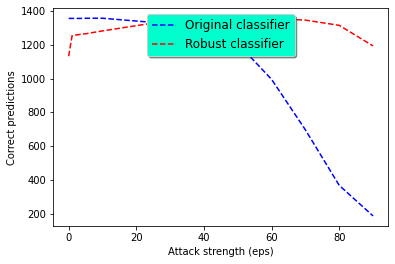

In [32]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Correct predictions')
plt.show()

Con esta grafica se observa claramente que el clasificador robusto, presentó un desempeño muchísimo mejor que el del clasificador orignal. Es importante mencionar que el desempeño del clasificador original fue descendente mientras que el del clasificador robusto fue ascendente.

In [33]:
joblib.dump(robust_classifier, 'model_malware_robust-parte2.h5')

['model_malware_robust-parte2.h5']